In [1]:
#@title Setting up environment
from google.colab import output

!git clone https://github.com/Quiexx/SpaceFace.git

!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!pip install huggingface_hub

output.clear()
print("Environment is set up")
%cd SpaceFace

Environment is set up
/content/SpaceFace


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Imports and functions
%cd stylegan2-ada-pytorch

import legacy
import pickle
import torch
import torchvision.transforms as T
import PIL
import dnnlib
import numpy as np
import copy
import math
import os
from huggingface_hub import hf_hub_download

def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

def add_imgs(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
  return new_im

%cd ..

/content/SpaceFace/stylegan2-ada-pytorch
/content/SpaceFace


In [4]:
#@title Loading models from huggingface


model_repo = "Quiexx/SpaceFace" #@param {"type": "string"}
source_model_name = "stylegan2-ffhq-1024x1024.pkl" #@param {"type": "string"}
tuned_model_name = "space_4.pkl" #@param {"type": "string"}


source_path = hf_hub_download(model_repo, source_model_name)
tuned_path = hf_hub_download(model_repo, tuned_model_name)

%cd stylegan2-ada-pytorch

device = torch.device("cuda")
with dnnlib.util.open_url(source_path) as f:
    source = legacy.load_network_pkl(f)["G_ema"].to(device)
with dnnlib.util.open_url(tuned_path) as f:
    tuned = legacy.load_network_pkl(f)["G_ema"].to(device)

%cd ..

def get_conv_names(model, max_dim=1024):
    val = 1 + int(np.log2(max_dim / 4))  # 9 for 1024, 8 for 512
    resolutions = [4 * 2 ** x for x in range(val)]
    names = [x[0] for x in list(model.named_parameters())]
    level_names = [["conv0", "const"], ["conv1", "torgb"]]
    position = 0
    conv_names = []
    for res in resolutions:
        rootname = f"synthesis.b{res}."
        for level, level_suffixes in enumerate(level_names):
            for suffix in level_suffixes:
                searchname = rootname + suffix
                matches = [x for x in names if x.startswith(searchname)]
                info_tuples = [(name, f"b{res}", level, position) for name in matches]
                conv_names.extend(info_tuples)
            position += 1
    return conv_names


def get_blended_model(
    G1, G2, resolution="b128", level=0, blend_width=None, network_size=512, verbose=False
):
    model1_names = get_conv_names(G1, network_size)
    model2_names = get_conv_names(G2, network_size)
    assert all((x == y for x, y in zip(model1_names, model2_names)))

    output_model = copy.deepcopy(G1)

    short_names = [(x[1:3]) for x in model1_names]
    full_names = [(x[0]) for x in model1_names]
    mid_point_idx = short_names.index((resolution, level))
    mid_point_pos = model1_names[mid_point_idx][3]

    ys = []

    for name, resolution, level, position in model1_names:
        x = position - mid_point_pos
        if blend_width:
            exponent = -x / blend_width
            y = 1 / (1 + math.exp(exponent))
        else:
            y = 1 if x > 1 else 0
        ys.append(y)
        if verbose:
            print(f"Blending {name} by {y}")

    new_model_state_dict = output_model.state_dict()
    for name, y in zip(full_names, ys):
        new_model_state_dict[name] = G2.state_dict()[name] * y + G1.state_dict()[
            name
        ] * (1 - y)
    output_model.load_state_dict(new_model_state_dict)

    return output_model

Downloading:   0%|          | 0.00/382M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382M [00:00<?, ?B/s]

/content/SpaceFace/stylegan2-ada-pytorch
/content/SpaceFace


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Seed: 1516689529626423296


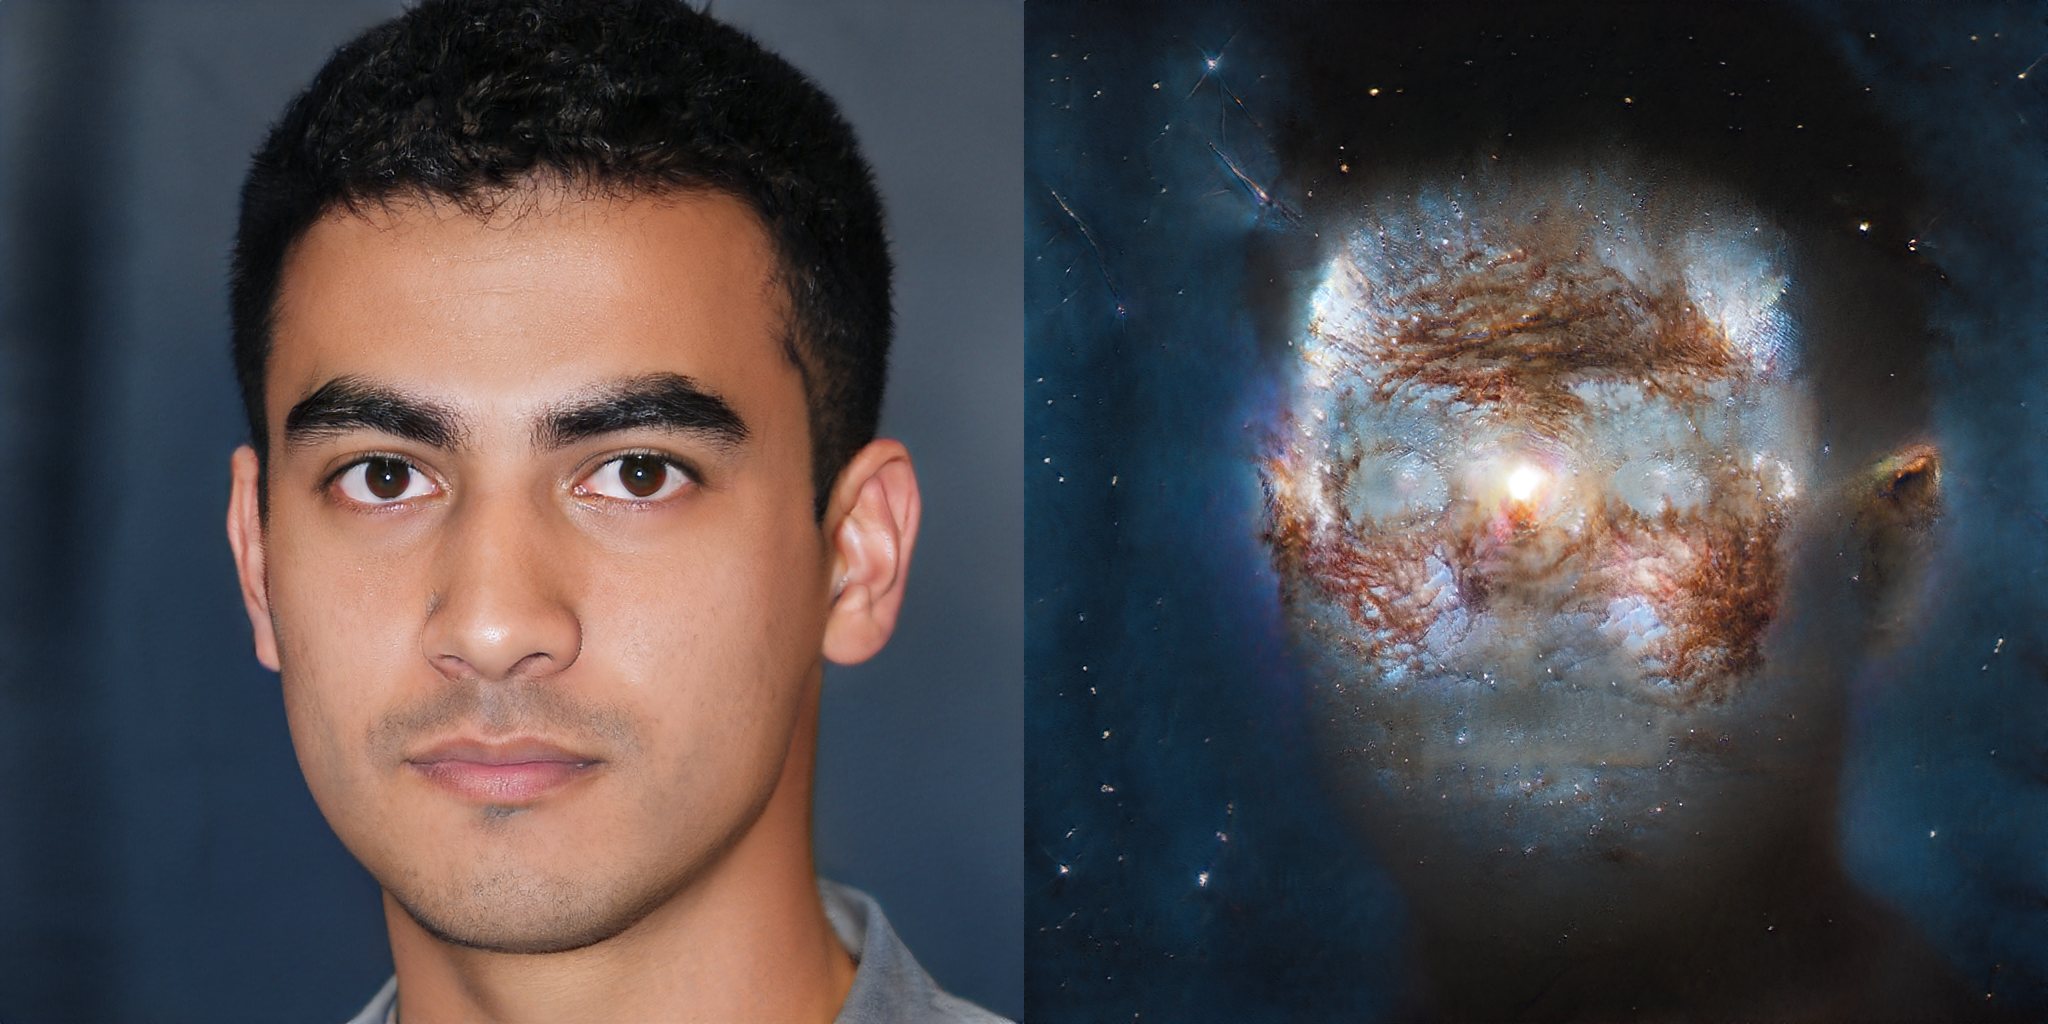

In [5]:
#@title Blend
#@markdown If seed is None, then torch.seed() is used
random_seed = 1516689529626423296 #@param

if random_seed is None:
  random_seed = torch.seed()

torch.manual_seed(random_seed)
z = torch.randn([1, source.z_dim]).cuda() 
w = source.mapping(z, None, truncation_psi=0.5, truncation_cutoff=8)

res = "b16" #@param ["b8", "b16", "b32", "b64", "b128", "b256"]
bw = None #@param
level = 0 #@param [0, 1]

blended = get_blended_model(
        source, tuned, resolution=res, level=level, blend_width=bw, network_size=1024, verbose=False
    )

                           
img1 = source.synthesis(w, noise_mode='const', force_fp32=True)
img2 = blended.synthesis(w, noise_mode='const', force_fp32=True)
img = add_imgs([t2i(img1), t2i(img2)])
print(f"Seed: {random_seed}")
display(img)

In [ ]:
#@title Save blended model

save_path = "../drive/MyDrive/space_face.pkl" #@param {"type": "string"}

with open(save_path, 'wb') as f:
    pickle.dump(blended, f)

print("Saved!")